# Deep Learning Portfolio 1

|Name|Github|Kaggle|
|----|------|------|
|Mohamed Belaachir|mobelaachir|Mo Belaachir|
|Jayden Debi-Tewari|Jaydendt1|jaydendt123|
|Quincy Soerohardjo|quincysoerohardjo2002|Quincy Soerohardjo|
|Michal Reszka-Gniecki|Ckires|michalreszkagniecki|

## Table of Contents
- [Data Overview](#data-overview)
- [Exploratory Data Analysis](#exploratory-data-analysis)
    - [Visualiseren](#visualiseren)
- [Feature Engineering](#feature-engineering)
    - [Analysis](#analysis)
- [Modeling](#modeling)
    - [LSTM voor audioclip](#Model1)
    - [LSTM voor songtekste](#Model2)
    - [Transformer voor songtekste](#Model3)
    - [Model naar keuze](#Model4)
- [Results](#results)
    - [Overview](#overview)
    - [Scores](#scores)
- [Conclusion & Advice](#conclusion--advice)
- [Sources](#sources)
- [Submission functie](#Submission-functie)
- [HTML functie](#HTML-functie)

In [ ]:
# !pip install keras-tuner --upgrade
# !pip install wordcloud
# !pip install audiomentations

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
import re
import seaborn as sns
import PIL
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from PIL import Image
from sklearn.preprocessing import StandardScaler
# from keras_tuner import HyperParameters  as hp
# import keras_tuner as kt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models
import IPython.display as ipd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Dense, Masking
import librosa
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding
import pathlib


## Data Overview

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Data importeren

In [ ]:
df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Portfolio 2 Datasets/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Portfolio 2 Datasets/test.csv')

In [ ]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# === Parameters ===
SAMPLE_RATE = 22050
N_MFCC = 20
SEGMENT_LEN = 216
HOP_LENGTH = 512
STRIDE = SEGMENT_LEN // 4  # overlap

# === Pad naar mappen ===
TRAIN_DIR = '/content/drive/My Drive/Colab Notebooks/Portfolio 2 Datasets/Train'
TEST_DIR = '/content/drive/My Drive/Colab Notebooks/Portfolio 2 Datasets/Test'

def extract_segments_from_audio(file_path, sr, n_mfcc, segment_len, hop_length, stride):
    """Extraheer MFCC-segmenten uit een audiobestand."""
    audio, _ = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length).T

    segments = [
        mfcc[i:i + segment_len]
        for i in range(0, len(mfcc) - segment_len + 1, stride)
        if mfcc[i:i + segment_len].shape[0] == segment_len
    ]
    return segments

def load_dataset(directory, sr, n_mfcc, segment_len, hop_length, stride, label_encoder=None, is_test=False):
    """Laad dataset met MFCC-segmenten uit de directory."""
    X, y = [], []

    if is_test:
        # Testbestanden zonder labels
        for filename in os.listdir(directory):
            if filename.endswith(('.wav', '.mp3')):
                file_path = os.path.join(directory, filename)
                segments = extract_segments_from_audio(file_path, sr, n_mfcc, segment_len, hop_length, stride)
                X.extend(segments)
                y.extend(['unknown'] * len(segments))
    else:
        # Trainingsdata met labels
        class_folders = sorted(os.listdir(directory))
        for label in class_folders:
            label_path = os.path.join(directory, label)
            for filename in os.listdir(label_path):
                file_path = os.path.join(label_path, filename)
                segments = extract_segments_from_audio(file_path, sr, n_mfcc, segment_len, hop_length, stride)
                X.extend(segments)
                y.extend([label] * len(segments))

        # Encodeer labels als one-hot
        y = label_encoder.transform(y)
        y = to_categorical(y)

    X = np.array(X)[..., np.newaxis]  # Voeg kanaaldimensie toe
    return X, y

def prepare_label_encoder(train_dir):
    """Creëer en train een label encoder op de trainingslabels."""
    labels = sorted(os.listdir(train_dir))
    encoder = LabelEncoder()
    encoder.fit(labels)
    return encoder

# Label encoder
label_encoder = prepare_label_encoder(TRAIN_DIR)

# Data laden
X_train, y_train = load_dataset(TRAIN_DIR, SAMPLE_RATE, N_MFCC, SEGMENT_LEN, HOP_LENGTH, STRIDE, label_encoder, is_test=False)
X_test, _ = load_dataset(TEST_DIR, SAMPLE_RATE, N_MFCC, SEGMENT_LEN, HOP_LENGTH, STRIDE, is_test=True)

# Splits train/validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

# Print informatie
print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Labels: {label_encoder.classes_}")


Train shape: (8608, 216, 20, 1)
Validation shape: (2153, 216, 20, 1)
Test shape: (2588, 216, 20, 1)
Labels: ['blues' 'country' 'disco' 'hiphop' 'metal' 'pop' 'reggae' 'rock']


In [ ]:
# Eerste model met 0.63 op kaggle was zonder batchnormalization
# met BatchNormalization is het 0.5 in kaggle

# === Model bouwen ===
from tensorflow.keras.layers import BatchNormalization, Bidirectional # Import Bidirectional

model = Sequential([
    # Reshape layer added to convert 4D to 3D
    layers.Reshape((segment_len, n_mfcc), input_shape=(segment_len, n_mfcc, 1)),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(16)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# === Model trainen ===
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_3 (Reshape)             │ (None, 216, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 216, 256)       │       152,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 216, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 216, 128)       │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 216, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 216, 64)        │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 216, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 32)             │        10,368 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 371,144 (1.42 MB)

 Trainable params: 371,144 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.3792 - loss: 1.6802 - val_accuracy: 0.6057 - val_loss: 1.0861
Epoch 2/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - accuracy: 0.5880 - loss: 1.1546 - val_accuracy: 0.6753 - val_loss: 0.9474
Epoch 3/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.6599 - loss: 0.9639 - val_accuracy: 0.6897 - val_loss: 0.8679
Epoch 4/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - accuracy: 0.7034 - loss: 0.8561 - val_accuracy: 0.7422 - val_loss: 0.7364
Epoch 5/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 22s 73ms/step - accuracy: 0.7580 - loss: 0.7257 - val_accuracy: 0.7733 - val_loss: 0.6419
Epoch 6/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.7531 - loss: 0.7278 - val_accuracy: 0.7845 - val_loss: 0.6238
Epoch 7/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - accuracy: 0.8057 - loss: 0.5829 - val_accuracy: 0.7487 - val_loss: 0.7742
Epoch 8/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.7749 - loss: 0.6716 - 

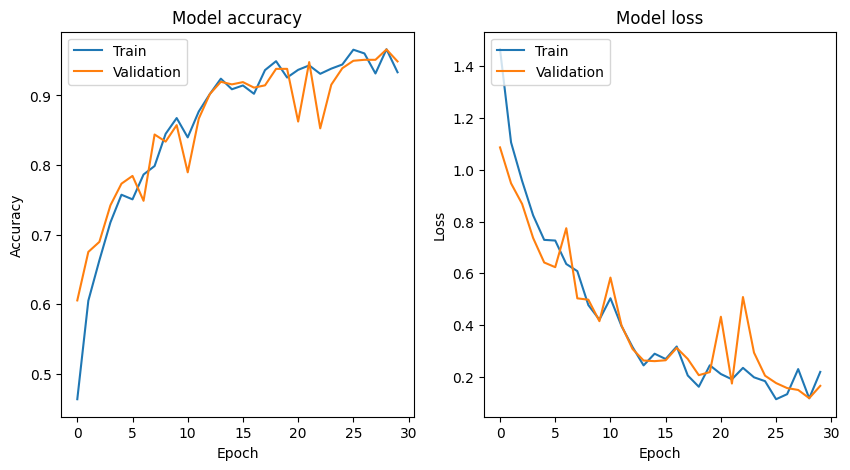

Test Loss: 0.1658
Test Accuracy: 0.9489


In [ ]:
# prompt: schrijf een code voor train accuracy en test accuracy

import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


In [ ]:
import os
import numpy as np
import librosa
import pandas as pd
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model

def extract_test_segments(test_dir, sr, n_mfcc, segment_len, hop_length, stride):
    """Laad test-audiobestanden en splits ze in overlappende MFCC-segmenten."""
    X_test = []
    filenames = []

    for file_name in os.listdir(test_dir):
        file_path = os.path.join(test_dir, file_name)
        if not file_path.endswith(('.wav', '.mp3')):
            continue

        audio, _ = librosa.load(file_path, sr=sr)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length).T
        segments = [
            mfcc[i:i + segment_len]
            for i in range(0, len(mfcc) - segment_len + 1, stride)
            if mfcc[i:i + segment_len].shape[0] == segment_len
        ]

        if segments:
            X_test.extend(segments)
            filenames.extend([file_name] * len(segments))

    X_test = np.array(X_test)[..., np.newaxis]
    return X_test, filenames

def predict_and_aggregate(model, X_test, filenames, label_encoder):
    """Voorspel genres en aggregeer de voorspellingen per bestand."""
    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_pred_labels = label_encoder.inverse_transform(y_pred_classes)

    pred_dict = defaultdict(list)
    for fname, label in zip(filenames, y_pred_labels):
        pred_dict[fname].append(label)

    final_predictions = {
        fname: Counter(labels).most_common(1)[0][0]
        for fname, labels in pred_dict.items()
    }

    return final_predictions


In [ ]:
def save_predictions_to_csv(predictions_dict, output_path="submission.csv"):
    """Sla voorspellingen op in een CSV-bestand in Kaggle-formaat."""
    df = pd.DataFrame(list(predictions_dict.items()), columns=['filename', 'genre'])
    df.to_csv(output_path, index=False)
    print(f"Voorspellingen opgeslagen in: {output_path}")


In [ ]:
# Parameters die je eerder hebt gebruikt

# Segmenten extraheren
X_test, filenames = extract_test_segments(TEST_DIR, SAMPLE_RATE, N_MFCC, SEGMENT_LEN, HOP_LENGTH, STRIDE)
print("Test shape:", X_test.shape)

# Voorspellen en aggregeren
final_predictions = predict_and_aggregate(model, X_test, filenames, label_encoder)

# Opslaan naar CSV
save_predictions_to_csv(final_predictions)


Test shape: (2588, 216, 20, 1)
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
Voorspellingen opgeslagen in: submission.csv


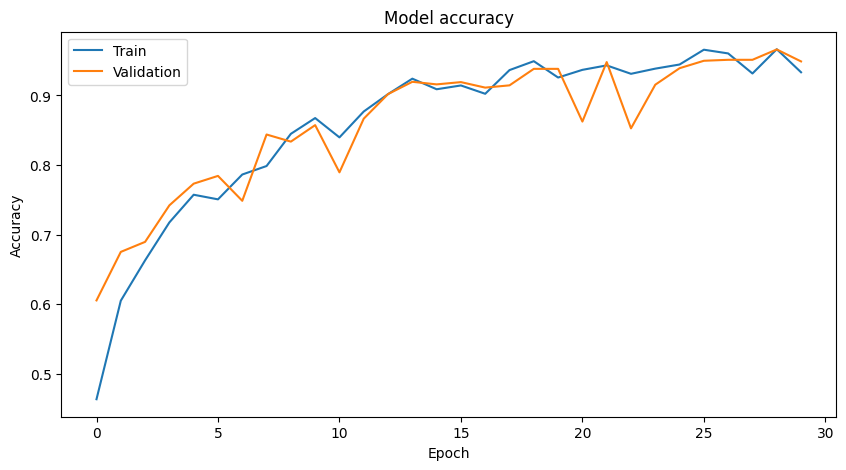

In [ ]:
# prompt: maak een plot

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step


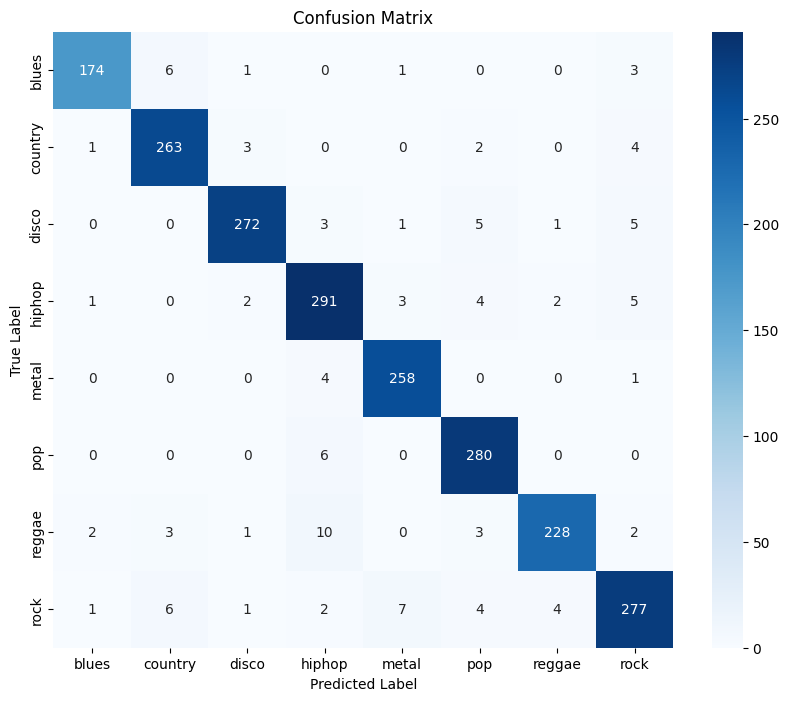

In [ ]:
# prompt: maak en confus matrix

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix # Import confusion_matrix

# Assuming you have y_pred (predicted labels) and y_true (true labels)
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1) # Convert probabilities to class labels
y_true = np.argmax(y_val, axis=1)  # Assuming y_val is one-hot encoded

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
df

,filename,genre
0,test.00001.wav,country
1,test.00003.wav,metal
2,test.00004.wav,rock
3,test.00002.wav,pop
4,test.00000.wav,country
...,...,...
124,test.00126.wav,disco
125,test.00124.wav,disco
126,test.00123.wav,reggae
127,test.00127.wav,reggae


In [ ]:
df.to_csv('pred16.csv', index=False)

In [ ]:
# base_dir = '/content/drive/My Drive/Colab Notebooks/Portfolio 2 Datasets/Train/'
# data_dir = pathlib.Path(base_dir)

# train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
#     directory=data_dir,
#     validation_split=0.2,
#     seed=0,
#     output_sequence_length=5*22050,
#     subset='both'
# )

# label_names = np.array(['blues', 'country', 'disco', 'hiphop', 'metal', 'pop', 'reggae', 'rock'])
# print()
# print("label names:", label_names)

Found 537 files belonging to 8 classes.
Using 430 files for training.
Using 107 files for validation.

label names: ['blues' 'country' 'disco' 'hiphop' 'metal' 'pop' 'reggae' 'rock']


## Exploratory Data Analysis

#### Train data

In [ ]:
df_train.head()

,filename,lyrics,genre
0,blues.00001.wav,I’m in the Mood Lyrics[Verse 1]\nI'm in the mo...,blues
1,blues.00002.wav,"(John Lee Hooker)\nThink twice before you go, ...",blues
2,blues.00003.wav,"[Intro, Spoken]\n...A little thing I'm going t...",blues
3,blues.00005.wav,"Sugar mama, sugar mama, sugar mama please come...",blues
4,blues.00006.wav,My baby left me this morning\nPeople just arou...,blues


#### Test data

In [ ]:
df_test.head()

,filename,lyrics
0,test.00000.wav,[Instrumental Intro]\n(Radio)\n(Radio)\n[Verse...
1,test.00001.wav,[Verse 1]\nThere's an old Kodak camera in my d...
2,test.00002.wav,"[Intro]\nSo curious, so curious\n\n[Verse 1]\n..."
3,test.00003.wav,[Intro]\nWhere do I take this pain of mine\nI ...
4,test.00004.wav,"[Verse 1]\nBaby's into runnin' around, hangin'..."


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  537 non-null    object
 1   lyrics    537 non-null    object
 2   genre     537 non-null    object
dtypes: object(3)
memory usage: 12.7+ KB


 De Data heeft 537 rijen met gegevens hebt, verdeeld over 3 kolommen: 'filename', 'lyrics' en 'genre'. Elke kolom bevat 537 niet-null waarden, wat betekent dat er geen missende data is. Het data type van alle kolommen is 'object', wat doorgaans betekent dat ze tekstuele data (strings) bevatten.

In [ ]:
df_train.describe()

,filename,lyrics,genre
count,537,537,537
unique,537,500,8
top,blues.00001.wav,"[Intro: Lil' Kim, Mýa, Christina Aguilera & P!...",rock
freq,1,4,79


#### Count
- Er zijn 537 bestandsnamen.

#### Unique
- Er zijn 537 unieke bestandsnamen.
- Er zijn 500 unieke sets van lyrics.
- Er zijn 8 unieke genres in je dataset.

#### Freq
- De bestandsnaam "rock.00099.wav" komt 1 keer voor.
- De meest voorkomende lyrics komen 4 keer voor.
- Het genre "rock" komt 79 keer voor in je dataset.


### Missende waarde:

In [ ]:
df_train.isnull().sum()

filename    0
lyrics      0
genre       0
dtype: int64

De df_train heeft geen missende waarden.

### Kolommen beschrijving:

filename: is uniek voor elk nummer.

lyrics bevat songteksten, sommige teksten lijken intro’s, stukken tekst of gesproken tekst te bevatten.

genre bevat 8 unieke genres.
Het meest voorkomende genre is rock (79 keer).

### Verdeling van genres

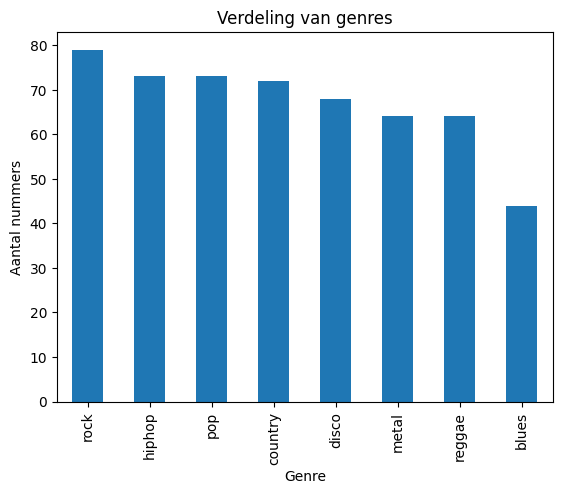

In [ ]:

# 1. Verdeling van genres
genre_counts = df_train['genre'].value_counts()

genre_counts.plot(kind='bar')
plt.title('Verdeling van genres')
plt.xlabel('Genre')
plt.ylabel('Aantal nummers')
plt.show()

De dataset vertoont een ongelijke verdeling van de muziekgenres. Het genre 'rock' is dominant en komt het meest frequent voor. 'Hiphop' en 'pop' vormen de op één na grootste categorieën. De overige genres ('country', 'disco', 'metal', 'reggae') zijn minder vertegenwoordigd, waarbij 'blues' significant de kleinste groep vormt. Deze disbalans in de genreverdeling kan relevant zijn voor downstream analyses en modeltraining.

### Woordwolken per genre

deze code genereert visuele woordwolken, één per muziekgenre in df_train. Elke woordwolk toont de meest gebruikte woorden in de songteksten van dat genre, waarbij grotere woorden vaker voorkomen. Dit geeft inzicht in de typische taal per genre.

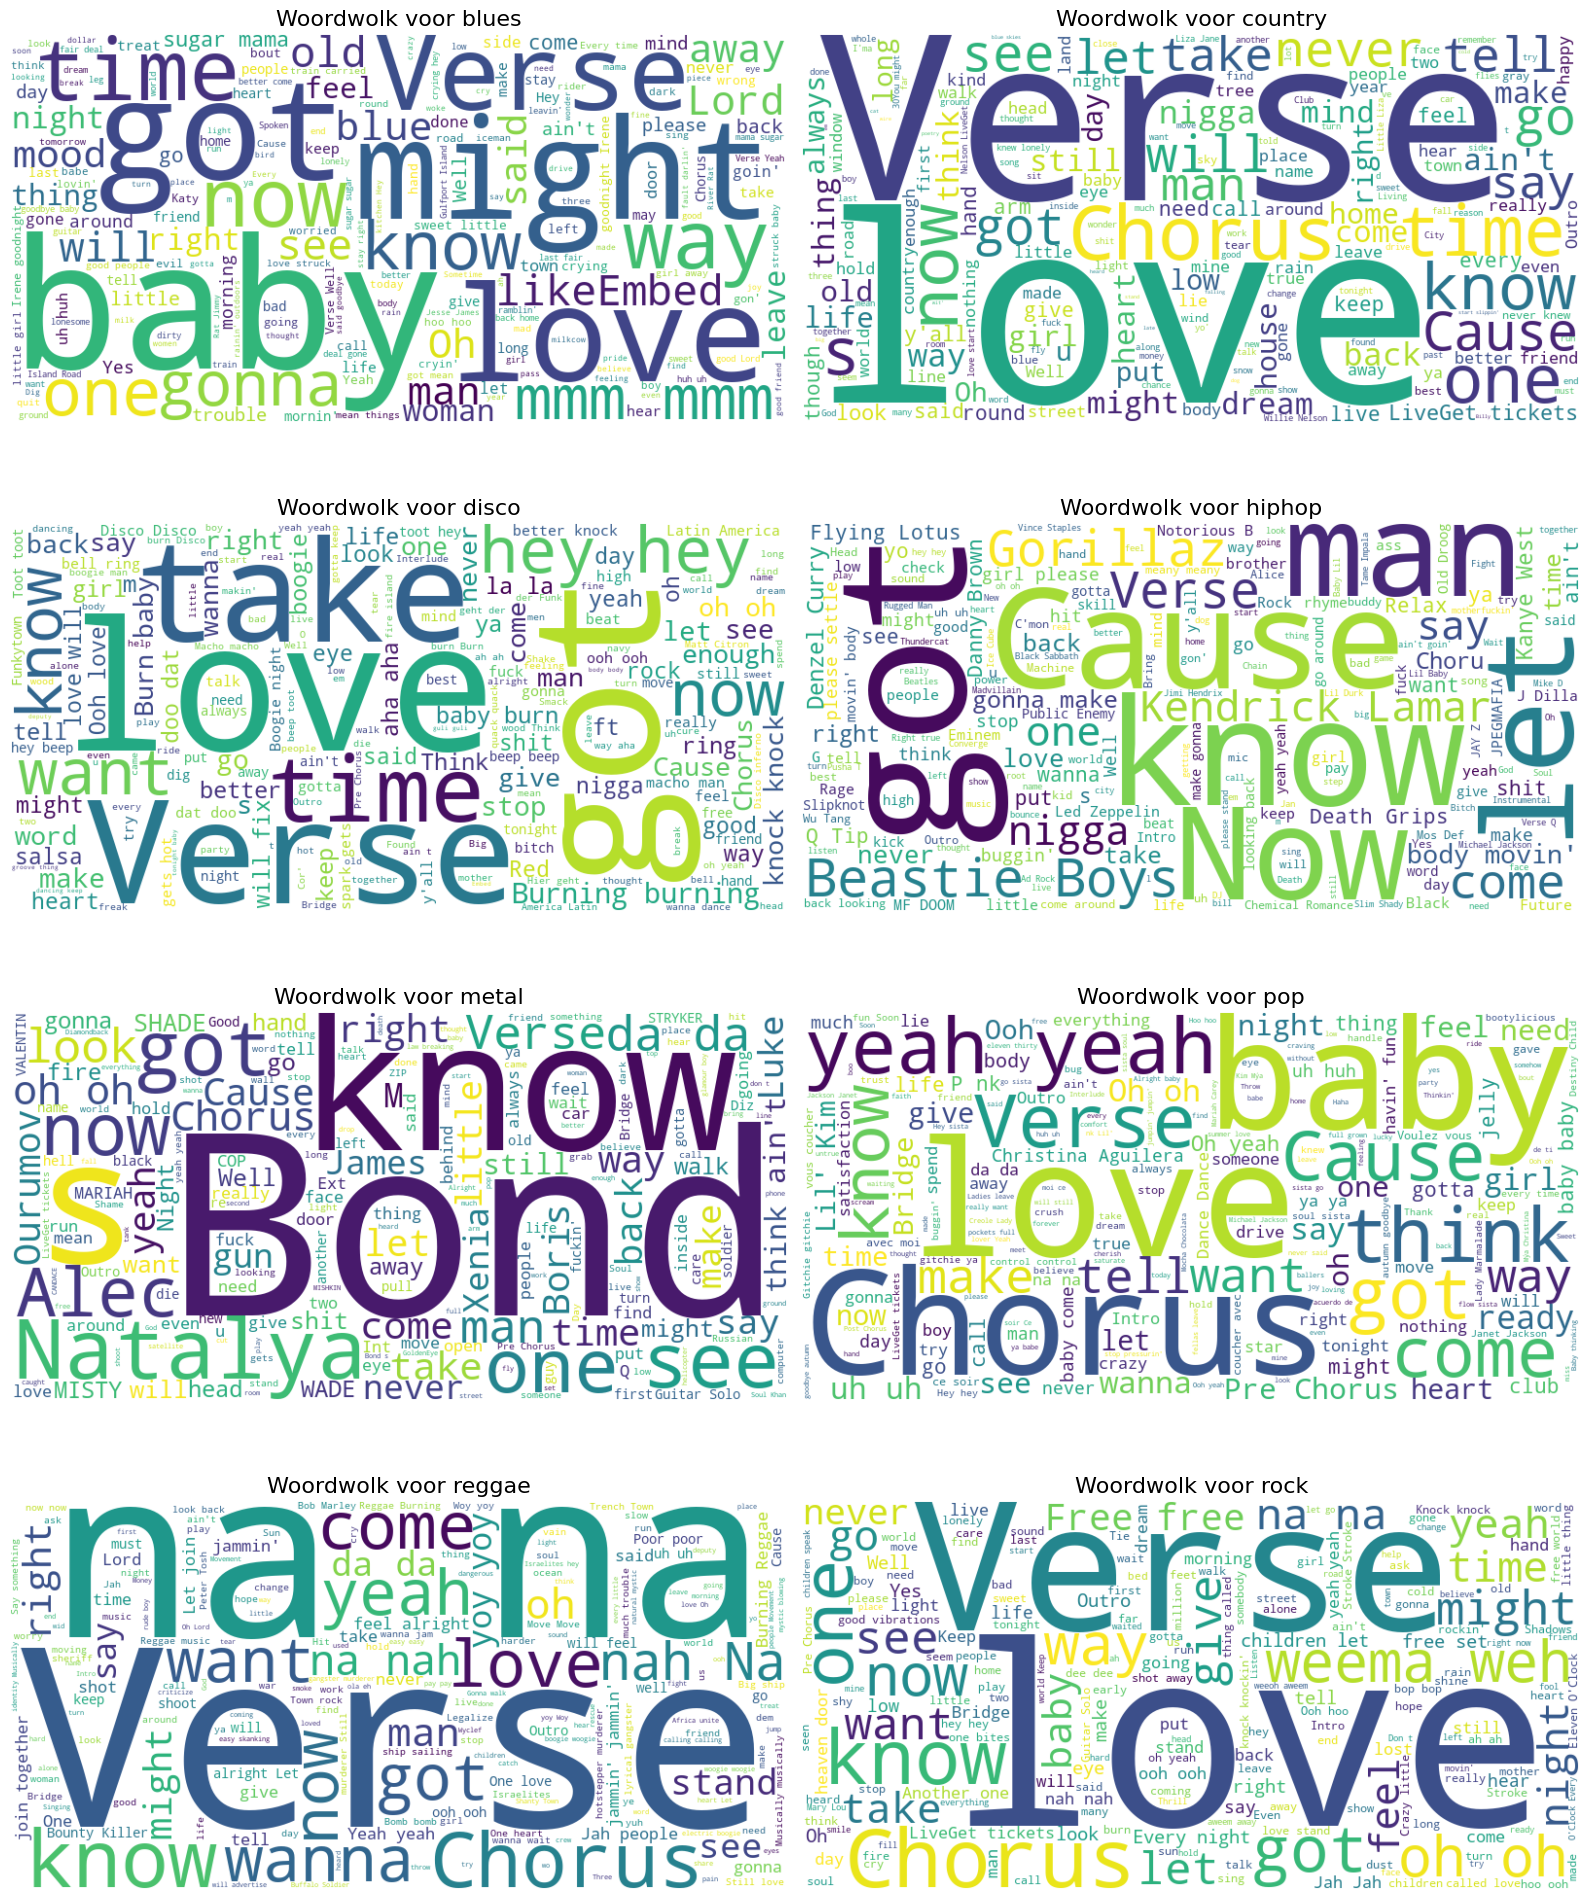

In [ ]:
# 3. Woordwolken per genre
genres = df_train['genre'].unique()
fig, axs = plt.subplots(len(genres)//2, 2, figsize=(16, 20))
axs = axs.flatten()

for i, genre in enumerate(genres):
    text = " ".join(df_train[df_train['genre'] == genre]['lyrics'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text) # Now WordCloud is defined
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].set_title(f'Woordwolk voor {genre}', fontsize=16)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

 De code downloadt de lijst van Engelse stopwoorden en slaat deze op in de variabele stop_words,

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alr3m\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


De code geeft een DataFrame terug met de 10 meest voorkomende woorden per genre, samen met hun aantallen in de songteksten van dat genre. Het resultaat geeft inzicht in welke woorden frequent voorkomen in verschillende genres, zonder stopwoorden en te korte woorden.

In [ ]:
# Genres ophalen
genres = df_train['genre'].unique()

# Lijst om alles te verzamelen
top_words_data = []

# Voor elk genre: Top 10 woorden ophalen
for genre in genres:
    # Alle lyrics van dit genre combineren
    lyrics = " ".join(df_train[df_train['genre'] == genre]['lyrics']).lower()

    # Woorden extraheren
    words = re.findall(r'\b\w+\b', lyrics)

    # Stopwoorden en korte woorden verwijderen
    filtered_words = [word for word in words if word not in stop_words and len(word) > 2]

    # Meest voorkomende woorden tellen
    most_common = Counter(filtered_words).most_common(10)

    # Data toevoegen aan de lijst
    for word, count in most_common:
        top_words_data.append({
            'Genre': genre,
            'Word': word,
            'Count': count
        })

# DataFrame maken
top_words_df = pd.DataFrame(top_words_data)
top_words_df.sort_values(by='Count', ascending=False)

,Genre,Word,Count
40,metal,bond,470
50,pop,yeah,430
51,pop,baby,421
30,hiphop,like,415
31,hiphop,get,362
...,...,...,...
5,blues,also,44
6,blues,little,40
7,blues,time,39
8,blues,like,37


De code geeft een DataFrame terug waarin de woorden staan die in meerdere genres voorkomen, samen met het aantal genres waarin elk woord voorkomt. Dit kan helpen bij het identificeren van woorden die genre-overstijgend zijn en in verschillende muziekstijlen worden gebruikt.

In [ ]:
# Eerst: alle unieke combinaties woord + genre
word_genre_pairs = top_words_df[['Word', 'Genre']]

# Groeperen: per woord tellen in hoeveel genres het voorkomt
word_genre_counts = word_genre_pairs.groupby('Word')['Genre'].nunique().reset_index()

# Alleen woorden die in meerdere genres zitten
common_words = word_genre_counts[word_genre_counts['Genre'] > 1]

# Resultaat tonen
display(common_words.sort_values(by='Genre', ascending=False).head())


,Word,Genre
16,like,8
18,love,6
30,verse,6
32,yeah,6
6,chorus,5


De code toont een DataFrame waarin elk woord staat dat in meer dan één genre voorkomt, samen met een lijst van de genres waarin dat specifieke woord voorkomt. Dit biedt gedetailleerde informatie over de spreiding van woorden over verschillende muziekgenres.

In [ ]:
# Genres per woord verzamelen
word_to_genres = top_words_df.groupby('Word')['Genre'].apply(list).reset_index()

# Alleen woorden met meerdere genres tonen
common_words_with_genres = word_to_genres[word_to_genres['Genre'].apply(lambda x: len(x) > 1)]

display(common_words_with_genres.head())


,Word,Genre
1,baby,"[blues, disco, pop]"
6,chorus,"[country, metal, pop, reggae, rock]"
9,get,"[disco, hiphop, pop]"
11,got,"[blues, disco, hiphop, metal]"
14,know,"[hiphop, metal, reggae, rock]"


Hier wordt er per genre een nummer afgespeeld

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Feature Engineering


De volgende features die aangemaakt worden zijn:
- Duration:
- Sample_rate:
- Spectral bandwidth:
- Spectral centroid:

In [ ]:
audio_features = []

# Loop through all files and extract features
for index, row in df_train.iterrows():
    filename = row['filename']
    file_path = os.path.join(base_dir, row['genre'], filename)

    # Load the audio file
    y, sr = librosa.load(file_path)

    # Calculate spectral bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    bandwidth_mean = np.mean(spectral_bandwidth)
    bandwidth_std = np.std(spectral_bandwidth)

    # Calculate spectral centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    centroid_mean = np.mean(spectral_centroid)
    centroid_std = np.std(spectral_centroid)

    # Store features and metadata in a dictionary
    features = {
        'filename': filename,
        'genre': row['genre'],
        'duration': librosa.get_duration(y=y, sr=sr),
        'sample_rate': sr,
        'spectral_bandwidth_mean': bandwidth_mean,
        'spectral_bandwidth_std': bandwidth_std,
        'spectral_centroid_mean': centroid_mean,
        'spectral_centroid_std': centroid_std
    }

    # Append the dictionary to the list
    audio_features.append(features)

# Create a Pandas DataFrame from the list of features
audio_features_df = pd.DataFrame(audio_features)

# Display the DataFrame (optional)
display(audio_features_df.head())

,filename,genre,duration,sample_rate,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_centroid_mean,spectral_centroid_std
0,blues.00001.wav,blues,30.013333,22050,2038.987608,462.498760,1530.261767,613.119490
1,blues.00002.wav,blues,30.013333,22050,1747.754087,276.216244,1552.832481,395.564168
2,blues.00003.wav,blues,30.013333,22050,1596.422564,408.107638,1070.153418,429.378632
3,blues.00005.wav,blues,30.013333,22050,1729.580804,449.272828,1832.011597,1015.127495
4,blues.00006.wav,blues,30.013333,22050,1389.068446,430.297945,1459.469691,661.834571


### Visualisaties

In deze grafiek worden de boxplots per genre gevisualiseerd per genre

In deze grafiek worden er boxplots van de spectral features gevisualiseerd.

## Modeling

# LSTM voor audioclip

## LSTM(Long short-term memory)

### Wat is LSTM?

LSTM staat voor Long Short-Term Memory. Het is een speciaal soort neuraal netwerk dat goed is in het verwerken van gegevens die in een bepaalde volgorde komen. LSTM is ontwikkeld om een bekend probleem van gewone recurrent neural networks (RNN’s) op te lossen, ze vergeten vaak belangrijke informatie die verder terug in de tijd ligt.

### Waarom is LSTM belangrijk?

LSTM is handig omdat het beter kan omgaan met lange afhankelijkheden in data. Gewone RNN's hebben vaak moeite om informatie die ver in het verleden ligt te onthouden. LSTM lost dit op door slimme geheugenmechanismen die beslissen wat je moet onthouden en wat je moet vergeten.

### Hoe werkt LSTM?

Een LSTM-eenheid bestaat uit een cel en drie belangrijke gates:

###**Forget gate:**
Deze poort bepaalt welke informatie uit het vorige geheugen moet worden weggegooid. Het geeft een waarde tussen 0 en 1, waarbij 0 betekent dat de informatie wordt weggestuurd en 1 betekent dat de informatie wordt behouden.

$$
f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
$$

- $f_t$: de "vergeetfactor"
- $h_{t-1}$: vorige hidden state
- $x_t$: huidige input
- $W_f, b_f$: gewichten en bias van de forget gate


###**Input gate:**
Deze poort beslist welke nieuwe informatie er moet worden opgeslagen in de cel.

#### a. Bepaal wat belangrijk is (input gate):

$$
i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
$$

#### b. Bereken de nieuwe kandidaat-waarden:

$$
\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
$$

- $i_t$: hoeveel van de nieuwe informatie gebruiken we?
- $\tilde{C}_t$: mogelijke nieuwe waarden om toe te voegen


###**Output gate:**
Deze poort bepaalt welke informatie uit de cel naar de volgende stap wordt gestuurd.

#### a. Bereken de output gate:

$$
o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
$$

#### b. Bepaal de hidden state (de uiteindelijke output van het LSTM-blok):

$$
h_t = o_t \cdot \tanh(C_t)
$$

- $o_t$: bepaalt hoeveel van $C_t$ zichtbaar is
- $h_t$: de uiteindelijke output van de LSTM op tijdstip $t$

[(Wikipedia contributors, 2025)](https://en.wikipedia.org/wiki/Long_short-term_memory), [(GeeksforGeeks, 2025)](https://www.geeksforgeeks.org/deep-learning-introduction-to-long-short-term-memory/)


Deze poorten gebruiken wiskundige functies, sigmoid-functie (geeft een waarde tussen 0 en 1) en tanh-functie (geeft een waarde tussen -1 en 1) om beslissingen te nemen.

De combinatie van deze onderdelen zorgt ervoor dat het model kan bepalen wat het moet onthouden, wat het moet vergeten, en wat het moet gebruiken om voorspellingen te doen.

[(GeeksforGeeks, 2025)](https://www.geeksforgeeks.org/deep-learning-introduction-to-long-short-term-memory/)




### Cell state

De cell state is een soort interne geheugenlijn die informatie over lange tijd kan bewaren. De poorten bewerken deze celtoestand stap voor stap. Als het nodig is, kan oude informatie worden weggehaald, en nieuwe informatie worden toegevoegd. Hierdoor blijft alleen de relevante informatie over.

### Hidden State

De hidden state is de uitvoer van de LSTM op een bepaald moment in de tijd. Deze uitvoer wordt bepaald door de informatie die in de cell state zit. Je kunt de hidden state zien als wat het netwerk "nu weet" en doorgeeft aan de volgende stap of gebruikt om een voorspelling te doen.

De hidden state wordt vooral beïnvloed door de output gate, die bepaalt welk deel van de cell state belangrijk genoeg is om uit te sturen.

[(Hamad, 2023)](https://medium.com/@rebeen.jaff/what-is-lstm-introduction-to-long-short-term-memory-66bd3855b9ce)



### Hoe leert een LSTM?

Net als andere neurale netwerken wordt een LSTM getraind met data. Daarbij gebruikt het een methode die Backpropagation Through Time (BPTT) heet. Hierbij wordt het netwerk terug in de tijd bekeken om fouten in voorspellingen te corrigeren. Dat gebeurt met behulp van wiskundige berekeningen, zodat het model steeds beter leert.

### Verschillende vormen van LSTM

Naast de standaardvorm zijn er ook andere varianten:

**Bidirectionele LSTM:** kijkt niet alleen naar het verleden, maar ook naar de toekomst in een reeks.

**Stacked LSTM:** meerdere LSTM-lagen worden op elkaar geplaatst voor diepere en krachtigere modellen.


### Waar wordt LSTM voor gebruikt?

LSTM wordt op veel verschillende gebieden toegepast, zoals:

- Het analyseren van tijdreeksen

- Spraakherkenning

- Machinevertaling

- Gezondheidszorg

- Robotbesturing

[(GeeksforGeeks, 2025)](https://www.geeksforgeeks.org/deep-learning-introduction-to-long-short-term-memory/)

##Bronnen:

- Wikipedia contributors. (2025, 3 mei). Long short-term memory. Wikipedia. https://en.wikipedia.org/wiki/Long_short-term_memory

- GeeksforGeeks. (2025, 5 april). What is LSTM Long Short Term Memory? GeeksforGeeks. https://www.geeksforgeeks.org/deep-learning-introduction-to-long-short-term-memory/

- Hamad, R. (2023, 11 december). What is LSTM? Introduction to Long Short-Term Memory. Medium. https://medium.com/@rebeen.jaff/what-is-lstm-introduction-to-long-short-term-memory-66bd3855b9ce

#### Hypertuning

#### Modelarchitectuur

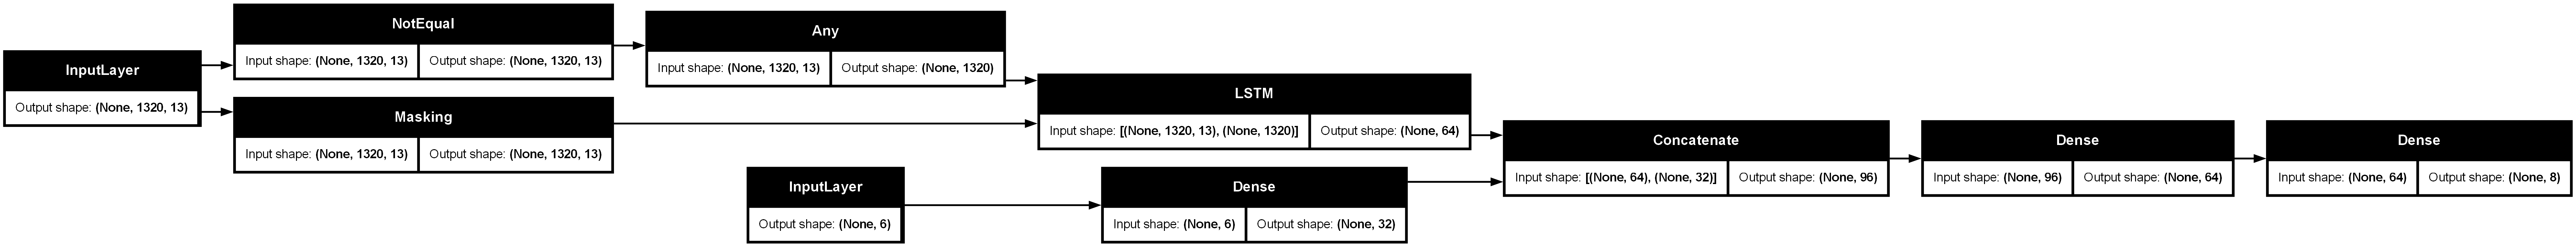

In [ ]:
plot_model(model, show_shapes=True, rankdir="LR")

#### Plot

#### Beste parameters  

# LSTM voor songtekste

In [ ]:
# Lyrics inladen

lyrics = df_train['lyrics'].values
genres = df_train['genre'].values

### Bepalen van vocabulary

In [ ]:
tokenizer = Tokenizer(num_words=8000)  # Pas num_words aan indien nodig
tokenizer.fit_on_texts(lyrics)
sequences = tokenizer.texts_to_sequences(lyrics)
vocab_size = len(tokenizer.word_index) + 1

### Bepalen van de sequence length

In [ ]:
# Bepalen van de sequence length (gebruik describe() voor inzicht)
df_subset = df_train.sample(n=200, random_state=42)
df_subset['seq_length'] = df_subset['lyrics'].astype(str).apply(lambda x: len(x.split()))
print(df_subset['seq_length'].describe())

# Aanpassen van max_length
max_length = int(df_subset['seq_length'].quantile(0.95)) # bijv. 95e percentiel
padded_sequences = pad_sequences(sequences, maxlen=max_length)

count      200.000000
mean       482.910000
std       1391.346299
min         44.000000
25%        197.000000
50%        270.500000
75%        451.500000
max      17073.000000
Name: seq_length, dtype: float64


In [ ]:
max_length = 640  # Pas max_length aan indien nodig
padded_sequences = pad_sequences(sequences, maxlen=max_length)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(genres)

In [ ]:
from tensorflow.keras.layers import TextVectorization
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')


# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 640

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)


In [ ]:
# Train/test split (nu met consistente lengtes)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42
)

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Verwijder leestekens
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Verwijder stopwoorden
    return text

df_train['processed_lyrics'] = df_train['lyrics'].apply(preprocess_text)

# Tokenizer
tokenizer = Tokenizer(num_words=5000)  # Pas num_words aan indien nodig
tokenizer.fit_on_texts(df_train['processed_lyrics'])
sequences = tokenizer.texts_to_sequences(df_train['processed_lyrics'])

# Padding
max_length = 400  # Pas max_length aan indien nodig
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Label encoding
le = LabelEncoder()
labels = le.fit_transform(df_train['genre'])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42
)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential()
model.add(Embedding(5000, 300, input_length=max_length))  # Pas embedding_dim aan indien nodig
model.add(LSTM(128))  # Pas units aan indien nodig
model.add(Dense(len(le.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

C:\Users\alr3m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))  # Pas epochs en batch_size aan indien nodig

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step - accuracy: 0.1540 - loss: 2.0739 - val_accuracy: 0.2778 - val_loss: 2.0454
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 276ms/step - accuracy: 0.5071 - loss: 1.9071 - val_accuracy: 0.2593 - val_loss: 1.9479
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - accuracy: 0.6141 - loss: 1.4364 - val_accuracy: 0.3796 - val_loss: 1.9334
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 279ms/step - accuracy: 0.7953 - loss: 0.9802 - val_accuracy: 0.2870 - val_loss: 2.1165
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 272ms/step - accuracy: 0.8411 - loss: 0.5761 - val_accuracy: 0.3056 - val_loss: 1.9438
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 274ms/step - accuracy: 0.9482 - loss: 0.2736 - val_accuracy: 0.3056 - val_loss: 2.0773
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - accuracy: 0.9754 - loss: 0.1286 - val_accuracy: 0.3148 - val_loss: 2.0896
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - accuracy: 0.9960 - loss: 0.0691 - val_accuracy: 0.

#### Hypertuning

#### Modelarchitectuur

Van BERT de enige toegepaste modellen voor onze opdracht zijn moddellen in het engels, getraind op zowel lower als uppercase. Bovendien

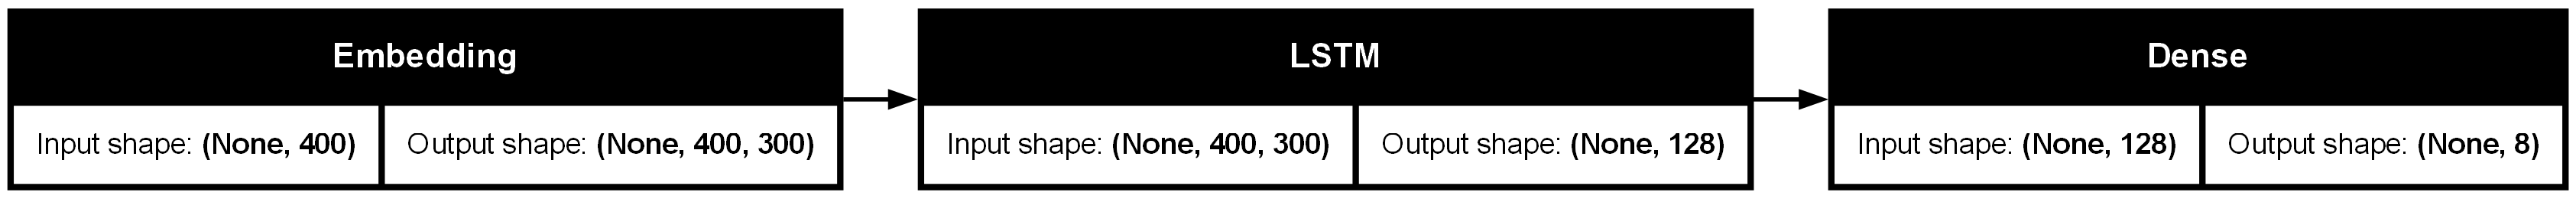

In [ ]:
plot_model(model, show_shapes=True, rankdir="LR")

#### Plot

#### Beste parameters  

# Transformer voor songtekste

#### Hypertuning

#### Modelarchitectuur

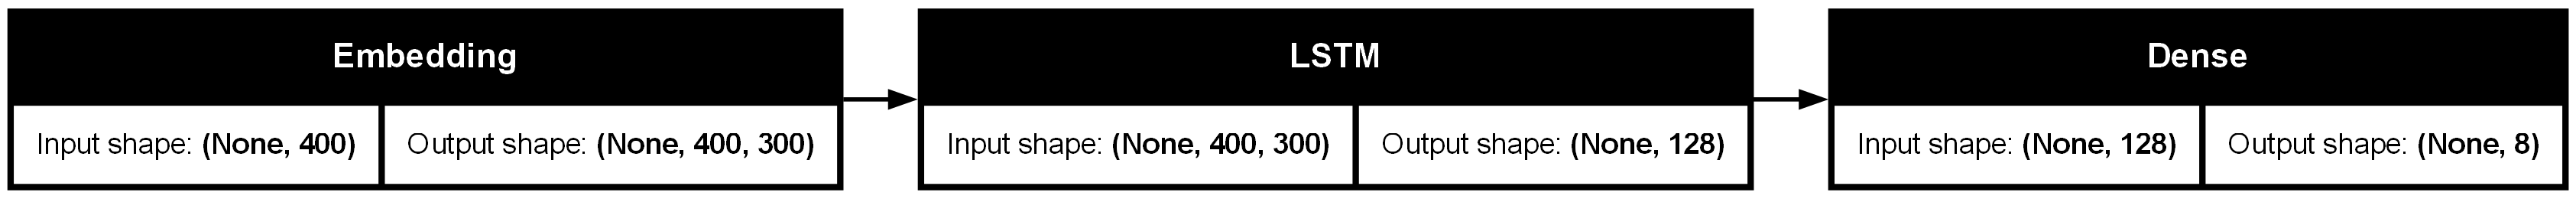

In [ ]:
plot_model(model, show_shapes=True, rankdir="LR")

#### Plot

#### Beste parameters  

# Model naar keuze

### Model code

#### Modelarchitectuur

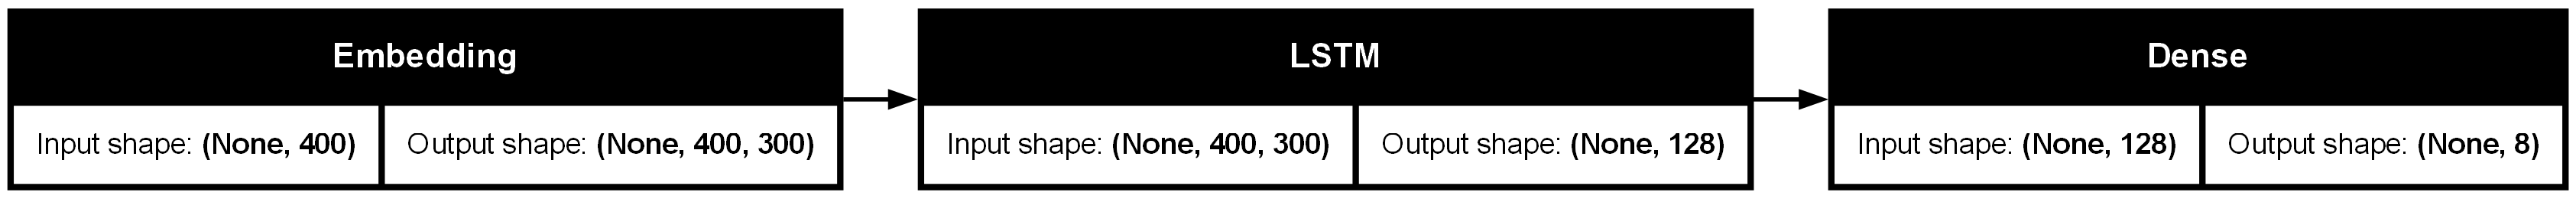

In [ ]:
plot_model(model, show_shapes=True, rankdir="LR")

#### Plot

### Hypertuning

#### Beste parameters



## Results

### Overview

### Scores

## Conclusion & Advice

|Model|Notebook|Kaggle|
|----|------|------|
||||
||||
||||
||||

### Submission functie

In [ ]:
import numpy as np
import pandas as pd

def create_submission(pred, df_test, filename, label_encoder):
    """
    Creates a submission file for Kaggle test data with genre predictions.

    Args:
        pred (np.ndarray): Predicted probabilities or class indices.
        df_test (pd.DataFrame): Test dataframe containing filenames.
        filename (str): Output CSV filename (must include .csv).
        label_encoder (LabelEncoder): Trained label encoder to decode genre indices.

    Returns:
        pd.DataFrame: Submission dataframe.
    """
    # Als pred probabilities bevat → neem hoogste waarschijnlijkheid
    if pred.ndim > 1 and pred.shape[1] > 1:
        pred_classes = np.argmax(pred, axis=1)
    else:
        pred_classes = pred.reshape(-1)

    # Decode genre-namen
    genre_labels = label_encoder.inverse_transform(pred_classes[:len(df_test)])

    # Maak het submission DataFrame
    submission_df = pd.DataFrame({
        'filename': df_test['filename'].values[:len(genre_labels)],
        'genre': genre_labels
    })

    # Sla op
    submission_df.to_csv(filename, index=False)

    return submission_df



In [ ]:
create_submission(y_pred, df_test, 'test.csv', label_encoder)

,filename,genre
0,test.00000.wav,hiphop
1,test.00001.wav,disco
2,test.00002.wav,blues
3,test.00003.wav,hiphop
4,test.00004.wav,hiphop
...,...,...
124,test.00124.wav,disco
125,test.00125.wav,rock
126,test.00126.wav,disco
127,test.00127.wav,pop


## Sources

### Html

In [ ]:
# Upload ipynb
from google.colab import files
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")

Saving Portfolio_1.ipynb to Portfolio_1.ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
import os
import glob
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from collections import Counter

# === Parameters ===
TRAIN_PATH = "/content/drive/My Drive/Colab Notebooks/Portfolio 2 Datasets/Train"
TEST_PATH = "/content/drive/My Drive/Colab Notebooks/Portfolio 2 Datasets/Test"
SAMPLE_RATE = 22050
N_MFCC = 20
SEGMENT_LENGTH = 216
HOP_LENGTH = 512
STRIDE = SEGMENT_LENGTH // 4

# === Functie: MFCC-segmenten genereren ===
def extract_mfcc_segments(audio_path, sr, n_mfcc, segment_len, hop_len, stride):
    audio, _ = librosa.load(audio_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, hop_length=hop_len).T
    return [mfcc[i:i + segment_len] for i in range(0, len(mfcc) - segment_len + 1, stride)
            if mfcc[i:i + segment_len].shape[0] == segment_len]

# === Functie: Trainingsdata laden ===
def load_train_data(base_dir, sr, n_mfcc, segment_len, hop_len, stride):
    features, labels = [], []
    class_names = sorted(os.listdir(base_dir))
    for label in class_names:
        for audio_file in glob.glob(os.path.join(base_dir, label, '*')):
            segments = extract_mfcc_segments(audio_file, sr, n_mfcc, segment_len, hop_len, stride)
            features.extend(segments)
            labels.extend([label] * len(segments))

    X = np.array(features)[..., np.newaxis]
    y_enc = LabelEncoder().fit(class_names)
    y = to_categorical(y_enc.transform(labels))
    return X, y, y_enc

# === Functie: Testdata laden ===
def load_test_data(test_dir, sr, n_mfcc, segment_len, hop_len, stride):
    X_test, filenames = [], []
    for audio_file in glob.glob(os.path.join(test_dir, '*.wav')) + glob.glob(os.path.join(test_dir, '*.mp3')):
        segments = extract_mfcc_segments(audio_file, sr, n_mfcc, segment_len, hop_len, stride)
        if segments:
            X_test.extend(segments)
            filenames.extend([os.path.basename(audio_file)] * len(segments))

    return np.array(X_test)[..., np.newaxis], filenames

# === Functie: Meest waarschijnlijke voorspelling per bestand ===
def get_final_predictions(filenames, predictions, encoder):
    labels = encoder.inverse_transform(predictions)
    df = pd.DataFrame({'filename': filenames, 'label': labels})
    final_df = df.groupby('filename')['label'].agg(lambda x: Counter(x).most_common(1)[0][0]).reset_index()
    final_df.columns = ['filename', 'genre']
    return final_df

# === Uitvoeren ===
X_train, y_train, encoder = load_train_data(TRAIN_PATH, SAMPLE_RATE, N_MFCC, SEGMENT_LENGTH, HOP_LENGTH, STRIDE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense, Reshape

def build_model(segment_length, num_mfcc, num_classes):
    model = Sequential([
        Reshape((segment_length, num_mfcc), input_shape=(segment_length, num_mfcc, 1)),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(32, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(16)),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
model = build_model(SEGMENT_LENGTH, N_MFCC, len(encoder.classes_))
model.summary()

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_3 (Reshape)             │ (None, 216, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 216, 256)       │       173,056 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 216, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 216, 128)       │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 216, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 216, 64)        │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 216, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 32)             │        10,368 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 391,624 (1.49 MB)

 Trainable params: 391,624 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.3759 - loss: 1.6681 - val_accuracy: 0.5885 - val_loss: 1.1112
Epoch 2/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.6083 - loss: 1.0854 - val_accuracy: 0.6916 - val_loss: 0.8714
Epoch 3/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.6710 - loss: 0.9336 - val_accuracy: 0.6373 - val_loss: 0.9771
Epoch 4/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.6678 - loss: 0.9394 - val_accuracy: 0.6902 - val_loss: 0.8407
Epoch 5/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.7550 - loss: 0.7207 - val_accuracy: 0.7924 - val_loss: 0.5909
Epoch 6/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.8206 - loss: 0.5545 - val_accuracy: 0.8216 - val_loss: 0.5149
Epoch 7/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.8494 - loss: 0.4612 - val_accuracy: 0.8509 - val_loss: 0.4924
Epoch 8/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - accuracy: 0.8803 - loss: 0.3907 - 

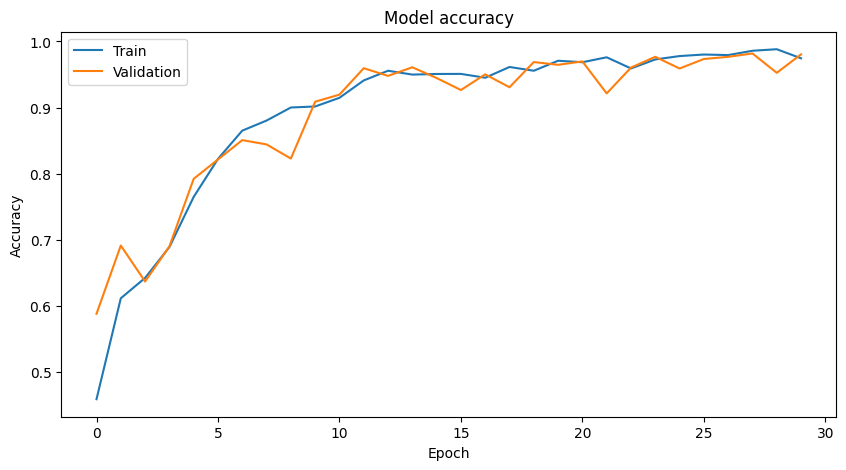

In [ ]:
# prompt: make a plot

import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# === Testdata laden en voorspellen ===
X_test, test_filenames = load_test_data(TEST_PATH, SAMPLE_RATE, N_MFCC, SEGMENT_LENGTH, HOP_LENGTH, STRIDE)
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# === Resultaten aggregeren ===
final_predictions_df = get_final_predictions(test_filenames, y_pred_classes, encoder)
final_predictions_df.to_csv('submission2.csv', index=False)
display(final_predictions_df.head())


81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


,filename,genre
0,test.00000.wav,rock
1,test.00001.wav,country
2,test.00002.wav,pop
3,test.00003.wav,metal
4,test.00004.wav,disco


68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


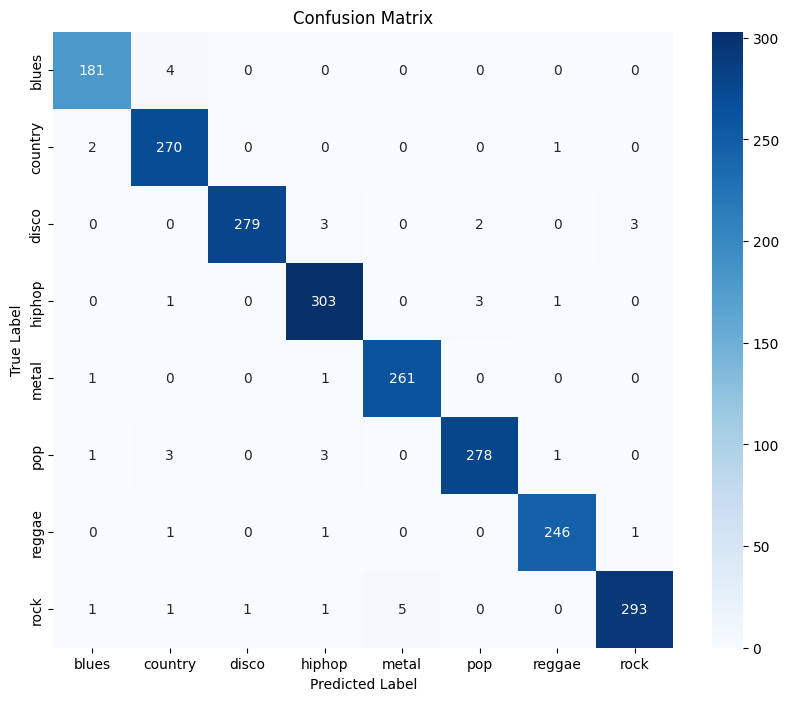

In [ ]:
# prompt: make a confus matrix

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have y_pred (predicted labels) and y_true (true labels)
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1) # Convert probabilities to class labels
y_true = np.argmax(y_val, axis=1)  # Assuming y_val is one-hot encoded

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
